In [4]:
# =============================================
# 1. Imports and Setup
# =============================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(1337)
tf.random.set_seed(1337)

# Enable GPU memory growth (optional but useful for avoiding memory allocation errors)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

# =============================================
# 2. Load and Preprocess MNIST Data
# =============================================
# Load MNIST dataset (60,000 training images and 10,000 test images)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values from [0, 255] to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# For CNNs, images need an explicit channel dimension.
# Expand dims from (num_samples, 28, 28) to (num_samples, 28, 28, 1) (grayscale channel)
x_train = np.expand_dims(x_train, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

# Split the training set into training and validation sets (80:20 split)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

# =============================================
# 3. Create tf.data.Datasets for Efficient Pipelining
# =============================================
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
          .shuffle(buffer_size=10000) \
          .batch(batch_size) \
          .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)) \
        .batch(batch_size) \
        .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
         .batch(batch_size) \
         .prefetch(tf.data.AUTOTUNE)

# =============================================
# 4. Build the CNN Model
# =============================================
model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),                    # Input layer: 28x28 grayscale image with 1 channel
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),                                  # Flatten the output from conv layers to a 1D vector
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10)                                   # Output layer: 10 neurons corresponding to 10 classes (logits output)
])

# model.summary()


In [5]:

# =============================================
# 5. Compile the Model
# =============================================
# Use Adam optimizer, and SparseCategoricalCrossentropy loss (with from_logits=True as the output layer doesn't use softmax)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# =============================================
# 6. Set Up Callbacks
# =============================================
# EarlyStopping: Stop training if validation loss doesn’t improve for 3 epochs,
# and restore the best model weights.
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ModelCheckpoint: Save the model when the validation loss improves.
# In Keras 3.x, use the .keras extension for saving or leave it without extension.
checkpoint = callbacks.ModelCheckpoint(filepath='/Users/sameerkhan/Desktop/sameerkhanAIData/computerVision/image-CNN-tf-Data.ipynb.keras', monitor='val_loss', save_best_only=True)

# =============================================
# 7. Train the Model
# =============================================
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8262 - loss: 0.5406 - val_accuracy: 0.9754 - val_loss: 0.0894
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9635 - loss: 0.1312 - val_accuracy: 0.9772 - val_loss: 0.0882
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9689 - loss: 0.1472 - val_accuracy: 0.9811 - val_loss: 0.1241
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9685 - loss: 0.2202 - val_accuracy: 0.9758 - val_loss: 0.2326
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9669 - loss: 0.3307 - val_accuracy: 0.9781 - val_loss: 0.3615


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9761 - loss: 0.0919
Test Loss: 0.0755, Test Accuracy: 0.9791
Model saved as '/Users/sameerkhan/Desktop/sameerkhanAIData/computerVision/image-CNN-tf-Data.ipynb.keras'.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,104 (2.58 MB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 450,070 (1.72 MB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
First 10 Predicted Labels: [7 2 1 0 4 1 4 9 5 9]
First 10 True Labels: [7 2 1 0 4 1 4 9 5 9]


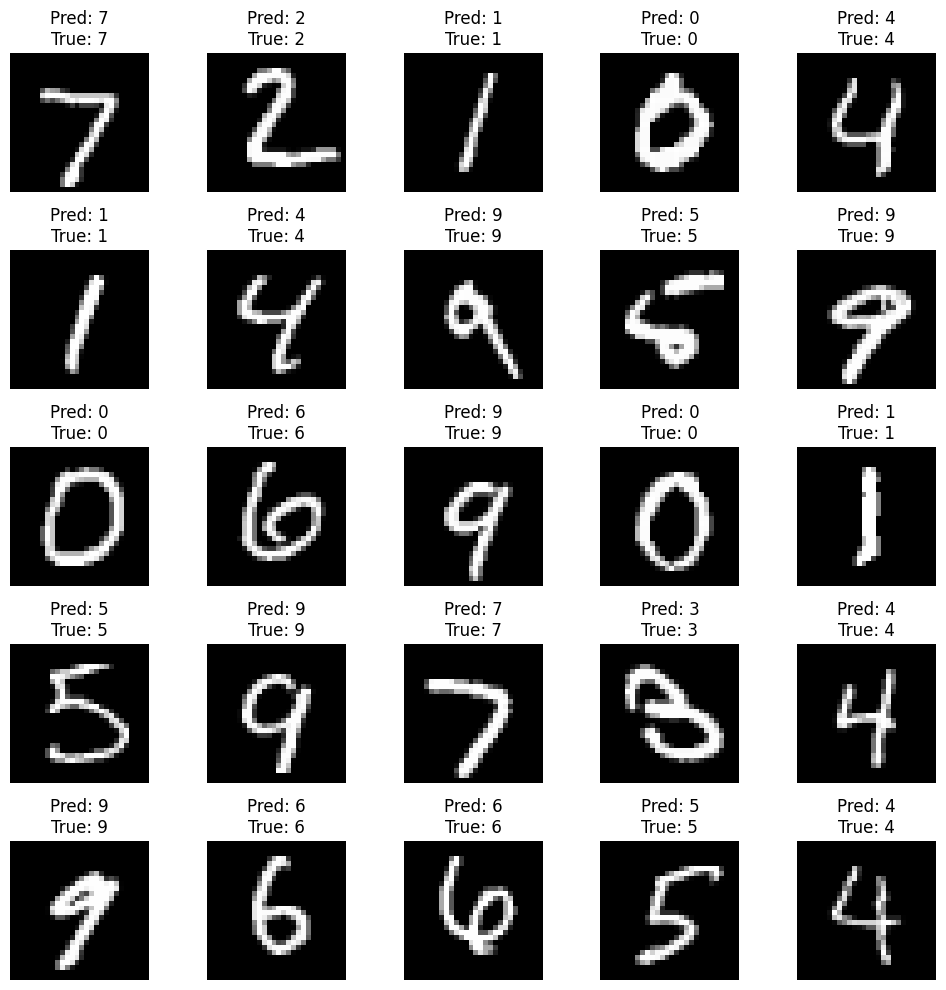

In [6]:

# =============================================
# 8. Evaluate the Model on the Test Set
# =============================================
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# =============================================
# 9. Save the Model
# =============================================
model_save_path = "/Users/sameerkhan/Desktop/sameerkhanAIData/computerVision/image-CNN-tf-Data.ipynb.keras"
model.save(model_save_path)
print(f"Model saved as '{model_save_path}'.")

# =============================================
# 10. Load the Saved Model and Make Predictions
# =============================================
loaded_model = tf.keras.models.load_model(model_save_path)
loaded_model.summary()

# Make predictions on test data (flattened images don't apply here because CNN expects images of shape (28,28,1))
predictions = loaded_model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

print("First 10 Predicted Labels:", predicted_labels[:10])
print("First 10 True Labels:", y_test[:10])

# =============================================
# 11. Visualize Some Predictions
# =============================================
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    # Reshape back to 28x28 for visualization
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {predicted_labels[i]}\nTrue: {y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()